In [53]:
# neccessities for the project setup
# this enables automatic reload of the libraries specific to this project
%load_ext autoreload
%autoreload 1

import os
import sys

# fs_utils.py stores paths to every other directory in the projects
# this module is located at the top level of the repository
# jupyter can't see it unless I change the cwd manually
# official man page tells that it's not actually possible in any other way
sys.path.append(os.path.abspath(".."))
%aimport fs_utils

# extend != append, the former appends the content while 
# the latter — the list with two elements...
os.chdir(fs_utils.ROOT_DIR)
sys.path.extend([fs_utils.LIB_DIR, fs_utils.ROOT_DIR, fs_utils.SRC_DIR])

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [54]:
# standard library
import gc
import pickle
import multiprocessing as mp

gc.enable()

In [55]:
# third-party modules
from collections import defaultdict, OrderedDict
from joblib import Parallel, delayed
import igraph as ig
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
%aimport matplotlib.font_manager
import numpy as np
import pandas as pd
import psutil
import scipy.stats as sps
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from statsmodels.stats.multitest import multipletests
from tqdm import tqdm_notebook

%matplotlib inline

In [63]:
# custom modules
%aimport util
%aimport qtls
%aimport networks
%autosave 15

Autosaving every 15 seconds


In [5]:
qtls_df = {
    "eQTLs_2011" : {
        "naive" : pd.read_table("./data/processed/eQTLs/2011/qtls_naive.csv"),
        "limix" : pd.read_table("./data/processed/eQTLs/2011/qtls_limix.csv")
    },
    "eQTLs_2018" : { 
        "A&B" : pd.read_table("./data/processed/eQTLs/2018/qtls_albert&bloom_from_paper.csv"),
        "limix" : pd.read_table("./data/processed/eQTLs/2018/qtls_limix.csv")
    }, 
    "pQTLs_2011" : {
        "naive" : pd.read_table("./data/processed/pQTLs/2011/qtls_naive.csv"),
        "limix" : pd.read_table("./data/processed/pQTLs/2011/qtls_limix.csv")
    }
}
qtls_df["eQTLs_2011"]["naive"]["score"] = qtls_df["eQTLs_2011"]["naive"]["q_value"]
qtls_df["pQTLs_2011"]["naive"]["score"] = qtls_df["pQTLs_2011"]["naive"]["q_value"]
qtls_df["eQTLs_2018"]["A&B"]["score"] = (1 - MinMaxScaler()\
                                               .fit_transform(
                                                    qtls_df["eQTLs_2018"]["A&B"]["LOD"].values[:,None]
                                                )
                                          )
for qtl_type in ["eQTLs_2011", "eQTLs_2018", "pQTLs_2011"]:
    qtls_df[qtl_type]["limix"]["score"] = qtls_df[qtl_type]["limix"]["q_value"]

# Physical and genetic interactions taken from TheBioGrid project
interactome_df = pd.read_table("./data/raw/interactions/yeast_interactome.csv")
# full_interactome_df = full_interactome_df[
#     full_interactome_df['Publication year'] <= 2011]

genetic_interaction_categories = [
    "additive genetic interaction defined by inequality",
    "suppressive genetic interaction defined by inequality",
    "synthetic genetic interaction defined by inequality"
]
physical_interaction_categories = [
    "association", 
    "colocalization", 
    "direct interaction",
    "physical association"
]

In [6]:
interactome_df.set_index('Interaction Type', inplace=True)

genetic_interactions_df = interactome_df[
    interactome_df.index.isin(genetic_interaction_categories)
]
physical_interactions_df = interactome_df[
    interactome_df.index.isin(physical_interaction_categories)
]

interaction_categories = (genetic_interaction_categories 
                          + physical_interaction_categories 
                          + ["all", "physical", "genetic"])

def extract_interactions(interactions_df):
    ''' Helper function to retrieve the edges of the graph of interactions '''
    return interactions_df[["Interactor A", "Interactor B"]].values

type2interactome = {}
for edge_type in interaction_categories:
    with open("./data/raw/interactions/{}_interactions_graph.pkl".format(edge_type), "rb") as infile:
        type2interactome[edge_type] = pickle.load(infile)

In [7]:
category = {"all" : "all"}
for edge_type in physical_interaction_categories + ["physical"]:
    category[edge_type] = "physical"
for edge_type in genetic_interaction_categories + ["genetic"]:
    category[edge_type] = "genetic"

## Implementation
**Introduction — interacting vs. random:**  
*“Interacting genes share more linkages than expected at random. The observation is robust under structure-preserving graph randomization.”*  

- For each edge, compute the Jaccard coefficient of the sets of markers linked to its endpoints. 
- Then create several thousands of random graphs using structure-preserving randomization of the interactome graph and compute the coefficients. 

Compare distributions of Jaccard coefficients through such statistics, as:

- p-value from MWU test
- mean value
- confidence intervals

A class generating this figure must reside in `qtls` module and be well-documented. 
Let's call it `RandomizedInteractomeTest`.  
I am very glad, that this test is already implemented. We just have to call it properly.

In [62]:
# Было бы очень неплохо добавить автоматические дампы.
# Скажем, с каким-то шагом пиклить целиком весь класс.
# Это реализовано из коробки в каком-нибудь пакете?

class RandomizedInteractomeTest:
    """
    Given a list of QTLs as (marker, gene) pairs and a graph of interactions,
    traverses all of its edges and calculates on the way the Jaccard similarity between
    sets of markers linked to edge's endpoints. When done, replaces the real interactome
    with random graphs obtained from it using structure-preserving randomization, and 
    repeats the computation. Two distributions — from actual and random edges — 
    are then compared by test statistics (mean value, confidence intervals etc).
    -----------------------------------------------------------------------------------
    This class was designed with map-reduce paradigm in mind. 
    """
    def __init__(self, interactome, interactions_type, qtls_df, score_thresholds, 
                 path_to_randomized, max_iter, n_jobs=-1):
        
        assert "SNP" in qtls_df.columns, "provided QTLs don't have marker column"
        assert "gene" in qtls_df.columns, "provided QTLs don't have gene column"
        assert "score" in qtls_df.columns, "provided QTLs don't have associated scores"
        assert np.all((0 <= qtls_df["score"]) & (qtls_df["score"] <= 1)),\
                "scores must be scaled to fit into (0, 1) range"
        assert np.all((0 <= score_thresholds) & (score_thresholds <= 1)),\
                "some thresholds are outside (0, 1) range"
        
        self.interactome = interactome
        self.interactions_type = interactions_type
        self.qtls_df = qtls_df
        self.score_thresholds = score_thresholds
        self.max_iter = max_iter
        
        self.n_edges = self.interactome.ecount()
        self.n_nodes = self.interactome.vcount()
        self.node_names = self.interactome.vs["name"]
        
        self.n_jobs = n_jobs if n_jobs > 0 else mp.cpu_count()
        self.simulation_results = defaultdict(list)
        self.path_to_randomized = os.path.abspath(path_to_randomized)
            
    def aggregate_jaccard_distributions(self, threshold, n_iter=10, agg_f=None):
        """
        Если так разобраться, то это и есть код, написанный летом.
        Можно убрать из map все отсылки к старой кодовой базе и использовать эту функцию.
        Хотя по-хорошему надо бы добавить к старой функции дефолтный параметр
        и использовать именно её, поскольку потом она всё равно понадобится при обработке модулей.
        Следовательно, после обкатки функционала его нужно усилием воли перенести в lib/.
        Хотя бы потому, что конкретно эту функцию нельзя запускать параллельно (а оч. хочется)
        """
        signif_qtls_df = self.qtls_df[self.qtls_df["score"] <= threshold]
        qtls_graph = networks.graph_from_edges(signif_qtls_df[["SNP", "gene"]].values, 
                                              directed=True)

        j_distr_dct = OrderedDict()
        real_linksim = np.array(
            qtls.linkage_similarity(
                self.interactome,
                qtls_graph,
                mode='full'
            )
        )
        j_distr_dct["real"] = (real_linksim 
                               if agg_f is None 
                               else agg_f(real_linksim))
        
        for iter_num in tqdm_notebook(range(n_iter), "randomized copy"):
            randomized_interactome = ig.Graph().Read_Pickle(
                os.path.join(self.path_to_randomized, 
                             "{0}/{1}.pkl".format(self.interactions_type, iter_num))
            ).simplify()
            randomized_interactome.vs.select(_degree=0).delete()
            randomized_linksim = np.array(
                qtls.linkage_similarity(
                    randomized_interactome,
                    qtls_graph,
                    mode='full'
                )
            )
            j_distr_dct["random_{}".format(iter_num)] = (randomized_linksim 
                                                         if agg_f is None 
                                                         else agg_f(randomized_linksim))

        return j_distr_dct
    
    @staticmethod
    def process_threshold(thresh, interactome, interactions_type, 
                          node_names, qtls_df, max_iter, path_to_randomized):
        """
        QTL filtering and Jaccard coefficient computation.
        ----------------------------------------------------------
        @param thresh — float — score cutoff
        @param edges_list — list(str)
            list of edges given as pairs of gene names
        @param node_names — list(str)
            list of gene names corresponding to the 
            nodes of the interactome graph
        @param qtls_df — pd.DataFrame
            must contain such columns as ["SNP", "gene", "score"]
        @param max_iter — int — number of randomization iterations
        ----------------------------------------------------------
        @returns    a dictionary with:
                    — mean jaccard similarity 
                      (for real interactome and for each simulation)
                    — list of p-values obtained through;
                      MWU test that compared the actual Jaccard 
                      coefficient distribution with those arising
                      during simulation runs;
                    — number of edges with at least one linked 
                      marker with score below current threshold.
        ----------------------------------------------------------
        @note   staticmethod decorator makes this method 
                compatible with joblib (or multiprocessing module)
        """
        
        signif_qtls_df = qtls_df[qtls_df["score"] <= thresh]
        linksim = {}
        # эм... а что онf возвращает-то вообще?
        # ясное дело, что никаких доверительных интервалов-то и нет!
        # та функция ведь __усредняет__ значение статистики, полученной
        # по семплированным графам! т.е. она возвращает __число__, а не вектор!
        # это подстава и грусть!
        # нужно срочно переделать и на будущее взять за правило 
        # перечитывать свой старый код
        linksim["actual"], linksim["random"], p_values = \
            qtls.ppin_test( # attention! old codebase
                module_genes=node_names,
                interactions_type=interactions_type, 
                interactome_graph=interactome,
                qtl_df=signif_qtls_df,
                n_iters=max_iter,
                path_to_randomized=path_to_randomized,
                return_pvalues=True
            )
        
        simulation_results = {
            "actual-mean-linksim" : linksim["actual"],
            "random-mean-linksim" : linksim["random"],
            # получается, коррекцию в таком случае делать не нужно?
            "p-value" : sps.combine_pvalues(p_values)[1]
        }
        del linksim, signif_qtls_df        
        return simulation_results

    def map(self):
        """
        Computes the averaged Jaccard similarity for real interactome.
        Then simulates self.max_iter random lists of edges and 
        repeats the computations with those. 
        
        Method's name comes form the fact that it distributes the
        simulation iterations among workers on cluster.
        --------------------------------------------------------------
        @returns None (results are stored at self.simulation_results)
        """
        mapped = \
            Parallel(n_jobs=self.n_jobs)(
                delayed(RandomizedInteractomeTest.process_threshold)(
                    thresh, self.interactome, self.interactions_type,
                    self.node_names, self.qtls_df, self.max_iter, self.path_to_randomized
                )
                for thresh in self.score_thresholds
            )
        
        for test_stat in ["actual-mean-linksim", "p-value"]:
            self.simulation_results[test_stat] = np.concatenate([np.atleast_1d(run[test_stat]) 
                                                                 for run in mapped])
            
        self.simulation_results["random-mean-linksim"] = np.vstack([run["random-mean-linksim"] 
                                                                    for run in mapped])
        
    def reduce(self, summarize=True):
        """
        Summarizes the self.simulation_results when asked to do so
        """
        if summarize:
            mapped = self.simulation_results # for brevity
            simulation_summary = {
                "linksim" : {
                    key : 
                    np.quantile(mapped["random-mean-linksim"], val, axis=1)
                    for key, val in zip(["25%", "50%", "75%"], 
                                        [0.25, 0.5, 0.75])
                }
            }
            actual_summary = {
                "linksim" : { "mean" : mapped["actual-mean-linksim"] }
            }
            return {"actual" : actual_summary, 
                    "p-value" : mapped["p-value"],
                    "random" : simulation_summary}
        return self.simulation_results
    
    def map_reduce(self, summarize=True):
        """
        Master-function that initiates the pipeline.
        """
        self.map()
        return self.reduce(summarize)

## Running the test suite on Albert&Bloom's eQTLs. 

As test requires a `score` feature, I applied min-max normalization to LOD scores provided in A&B's dataset and inverted the values: 

$$\mathrm{score} = 1 - \mathrm{MinMaxScale(LOD)}$$

It's necessary to subtract the normalized value, because by design it's expected that the less the score the better.

### Computing similarity curves

In [60]:
""" Run simulations from scratch and dump results on disk. """

score_thresholds = np.linspace(0.8, 1, 10) # chosen empirically
# type2simulation_results = {}

In [64]:
assert np.all(score_thresholds == np.linspace(0.8, 1, 10))    
for edge_type in tqdm_notebook(["physical"]):
    print(edge_type)
    spr_test = RandomizedInteractomeTest(
        interactome=type2interactome[edge_type], 
        interactions_type=category[edge_type],
        qtls_df=qtls_df["eQTLs_2018"]["A&B"],
        score_thresholds=score_thresholds,
        path_to_randomized="data/raw/randomized_interactome_copies/",
        max_iter=128, 
        n_jobs=score_thresholds.size
    )
    type2simulation_results[edge_type] = spr_test.map_reduce()

physical


In [ ]:
# with open("data/tmp/figure-2/type2simulation_results_A&B_eQTLs_2018.pkl", "wb") as outfile:
#     pickle.dump(type2simulation_results, outfile)

In [10]:
with open("data/tmp/figure-2/type2simulation_results_A&B_eQTLs_2018.pkl", "rb") as infile:
    type2simulation_results = pickle.load(infile)

### Comparing distributions of Jaccard coefficients:

In [ ]:
spr_test = RandomizedInteractomeTest(
    interactome=type2interactome["physical"], 
    interactions_type=category["physical"],
    qtls_df=qtls_df["eQTLs_2018"]["A&B"],
    score_thresholds=score_thresholds,
    path_to_randomized="data/raw/randomized_interactome_copies/",
    max_iter=128, 
    n_jobs=score_thresholds.size)

j_distr_dct = spr_test.aggregate_jaccard_distributions(
    threshold=1.0, 
    n_iter=1024, 
    agg_f=lambda v: (v.size, (v == 0).sum())
)

In [40]:
fisher_pvalue_lst = []
for i in tqdm_notebook(range(1024)):
    n, real_0 = j_distr_dct["real"]
    n, random_0 = j_distr_dct["random_{}".format(i)]
    crosstab = pd.DataFrame([[real_0, n - real_0], [random_0, n - random_0]], 
                            columns=["== 0", "> 0"], 
                            index=["real", "random"])
    odds, pvalue = sps.fisher_exact(crosstab)
    fisher_pvalue_lst.append(pvalue)
signif, fisher_pvalue_lst, _, _ = multipletests(fisher_pvalue_lst)
print(signif.mean())


1.0


In [41]:
crosstab

,== 0,> 0
real,76697,13262
random,78603,11356


In [44]:
spr_test = RandomizedInteractomeTest(
    interactome=type2interactome["physical"], 
    interactions_type=category["physical"],
    qtls_df=qtls_df["eQTLs_2018"]["A&B"],
    score_thresholds=score_thresholds,
    path_to_randomized="data/raw/randomized_interactome_copies/",
    max_iter=128, 
    n_jobs=score_thresholds.size)

j_distr_dct = spr_test.aggregate_jaccard_distributions(
    threshold=1.0, 
    n_iter=5
)

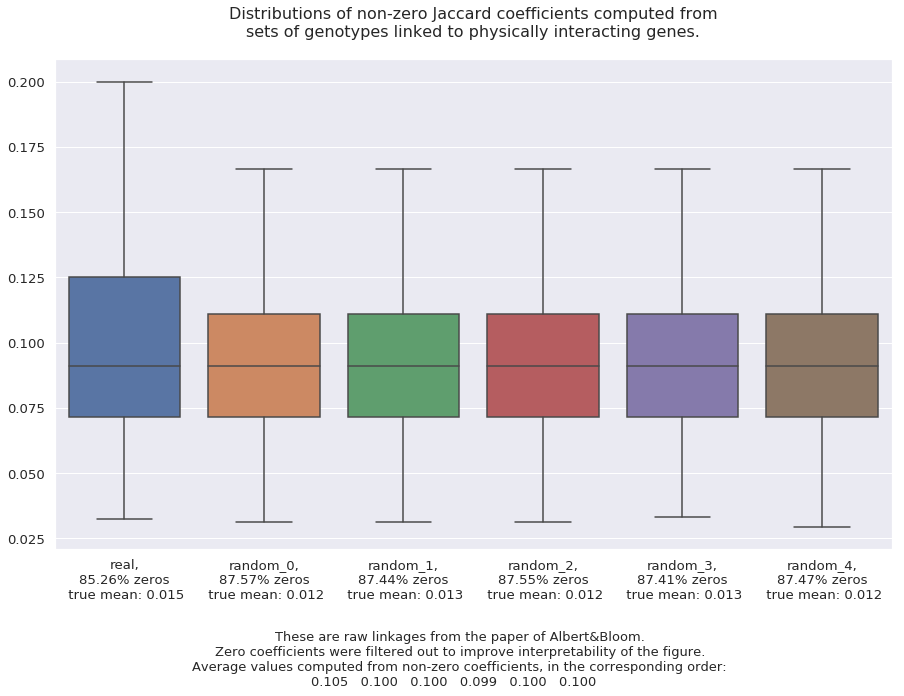

In [45]:
import matplotlib.font_manager
sns.set(style="darkgrid", font_scale=1.2)
sns.set_style({'font.family':'serif'})

fig, ax = plt.subplots(1, 1, figsize=(15, 10))

ax.set_title("Distributions of non-zero Jaccard coefficients computed from\n" 
             "sets of genotypes linked to physically interacting genes.\n", fontsize=16)
g = sns.boxplot(
    data=[v[v > 0] for v in j_distr_dct.values()], 
    ax=ax,
    showfliers=False
)

g.set_xticklabels(["{},\n{:.2f}% zeros\n true mean: {:.3f}".format(
    k, 100 * (v == 0).mean(), v.mean(), v[v>0].mean()) 
    for k, v in j_distr_dct.items()]
)

caption = ("These are raw linkages from the paper of Albert&Bloom.\n" 
           + "Zero coefficients were filtered out to improve interpretability of the figure.\n"
           + "Average values computed from non-zero coefficients, in the corresponding order:\n"
           + ''.join(["{:.3f}   ".format(v[v>0].mean()) for v in j_distr_dct.values()]))

fig.text(0.5, 0.010, 
         caption, 
         wrap=True, 
         horizontalalignment='center', 
         fontsize=13)

fig.subplots_adjust(bottom=0.2)

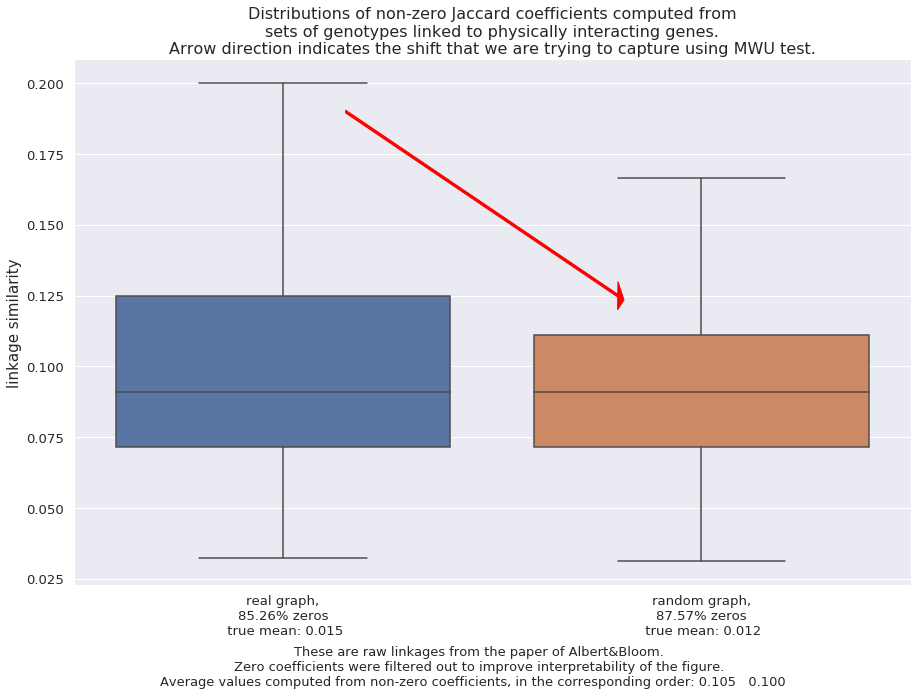

In [46]:
import matplotlib.font_manager
sns.set(style="darkgrid", font_scale=1.2)
sns.set_style({'font.family':'serif'})

fig, ax = plt.subplots(1, 1, figsize=(15, 10))

ax.set_title("Distributions of non-zero Jaccard coefficients computed from\n" 
             "sets of genotypes linked to physically interacting genes.\n"
             "Arrow direction indicates the shift that we are trying to capture using MWU test.", fontsize=16)

# ax.set_ylim(0, 1)
g = sns.boxplot(
    data=[v[v > 0] for v in j_distr_dct.values()][:2], 
    ax=ax,
    showfliers=False
)

g.set_xticklabels(["{} graph,\n{:.2f}% zeros\n true mean: {:.3f}".format(
    k.split("_")[0], 100 * (v == 0).mean(), v.mean(), v[v>0].mean()) 
    for k, v in j_distr_dct.items()][:2]
)

caption = ("These are raw linkages from the paper of Albert&Bloom.\n" 
           + "Zero coefficients were filtered out to improve interpretability of the figure.\n"
           + "Average values computed from non-zero coefficients, in the corresponding order: "
           + ''.join(["{:.3f}   ".format(v[v>0].mean()) for v in j_distr_dct.values()][:2]))

ax.arrow(0.15, 0.19, 
         0.65, -0.065, 
         color="red", head_width=0.01)

ax.set_ylabel("linkage similarity", fontsize=15)
fig.text(0.5, 0.010, 
         caption, 
         wrap=True, 
         horizontalalignment='center', 
         fontsize=13)

fig.subplots_adjust(bottom=0.15)

In [72]:
def plot_figure_2(fig, ax, type2interactome, type2simulation_results, 
                  interaction_categories, score_thresholds, 
                  suptitle, caption, 
                  colors, xscale_log=False):
    """
    This figure illustrates the observation that interacting genes tend
    to share more linkages than gene pairs selected uniformly at random
    
    Initially implemented 19.03.2019. 
    Usage examples can be found in figure-2.ipynb (look for relevant commits)
    -------------------------------------------------------------------------
    @param fig — matplotlib figure
    @param gs — matplotlib.gridspec — GridSpec object associated with fig
    @param ax — matplotlib axis — axis associated with gs
    @param type2interactome — dict(str, igraph.Graph)
        interactomes associated with different interaction categories
    @param type2simulation_results — dict of dicts 
        RandomizedInteractomeTest result
    @param interacton_categories — list(str) — categories to plot
    @param score_thresholds — list(float) — thresholds for linkage filtration
    @param suptitle — str — title for fig
    @param caption — str — caption for fig
    @param colors — dict(str, str) — colors for each interaction category
    -------------------------------------------------------------------------
    -------------------------------------------------------------------------
    @todo introduce more flexibility to figure aesthetics specification
    """
    assert (np.intersect1d(interaction_categories, list(type2interactome.keys())).size 
            == len(interaction_categories)),\
            "some passed categories are not present in simulation results: {}".format(
                np.setdiff1d(interaction_categories, list(type2interactome.keys()))
            )
    assert (np.intersect1d(interaction_categories, list(type2simulation_results.keys())).size 
            == len(interaction_categories)),\
            "some passed categories are not present in simulation results: {}".format(
                np.setdiff1d(interaction_categories, list(type2simulation_results.keys()))
            )
    
    sns.set(style="darkgrid", font_scale=1.3)
    sns.set_style({'font.family':'serif'})
    
    fig.subplots_adjust(bottom=0.2, top=0.85, wspace=0.1)
    fig.suptitle(suptitle, fontsize=25)
    fig.align_labels(axs=ax)
    fig.text(0.5, 0.025, caption, wrap=True, horizontalalignment='center', fontsize=18)

    ax.set_title("Linkage similarity by score threshold", fontsize=22, pad=10)
    ax.set_xlabel("linkage score threshold", fontsize=22, labelpad=10)
    ax.set_ylabel("average linkage similarity", fontsize=22, labelpad=10)
    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    if xscale_log: ax.set_xscale("log")
    
    for edge_type in interaction_categories:
        simulation_results = type2simulation_results[edge_type]
        significant_point_ids = list(np.where(np.ravel(simulation_results["p-value"]) <= 0.05))
        ax.plot(score_thresholds, 
                 simulation_results["actual"]["linksim"]["mean"], 
                 label="{}\nnodes: {}\nedges: {}".format(edge_type, 
                                                        type2interactome[edge_type].vcount(), 
                                                        type2interactome[edge_type].ecount()), 
                 color=colors[edge_type],
                 linestyle="-.",
                 marker="*",
                 markevery=significant_point_ids,
                 markerfacecolor="gold",
                 markersize=15
               )
        ax.plot(score_thresholds, 
                 simulation_results["random"]["linksim"]["50%"], 
                 c=colors[edge_type])
        ax.fill_between(score_thresholds, 
                         simulation_results["random"]["linksim"]["25%"],  
                         simulation_results["random"]["linksim"]["75%"], 
                         color=colors[edge_type], alpha=0.25)

        legend = ax.legend(loc="upper left", fontsize=15);
        frame = legend.get_frame();
        frame.set_facecolor("white");
        frame.set_edgecolor("black");
        ax.ticklabel_format(style='sci', axis='y', scilimits=(-2,2))
        

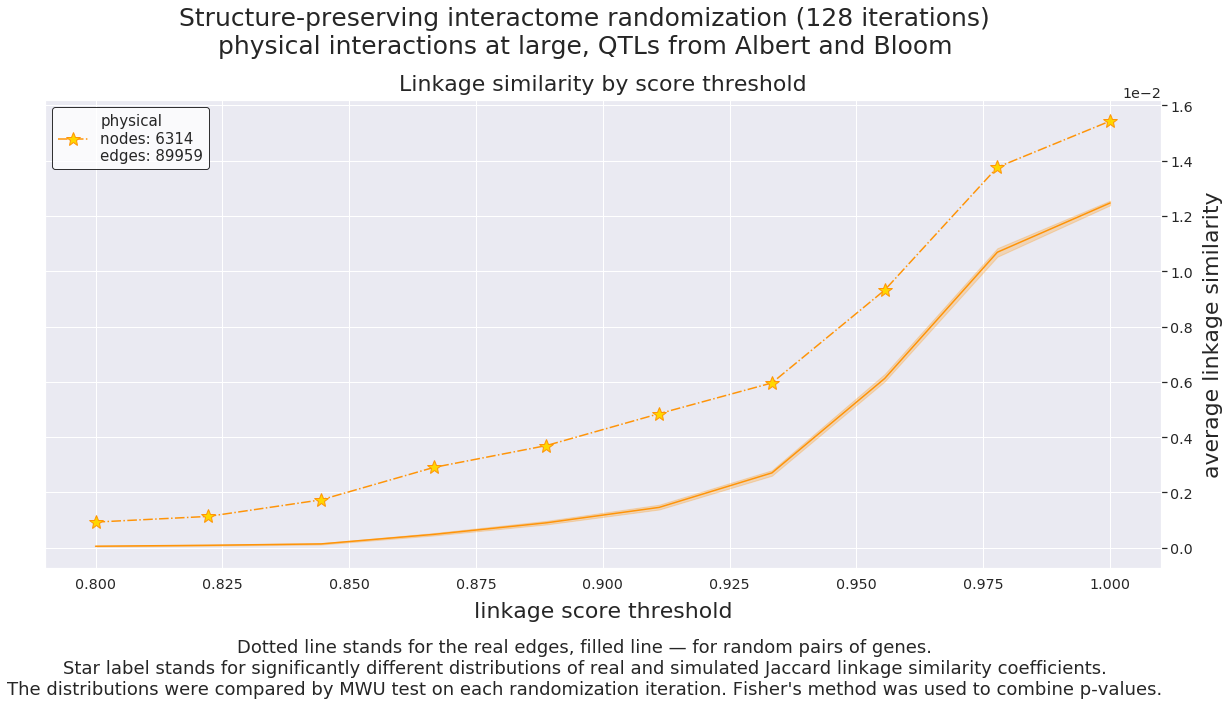

In [73]:
fig, ax = plt.subplots(figsize=(20,10))

plot_figure_2(
    fig, ax, type2interactome, type2simulation_results, 
    interaction_categories=["physical"],
    score_thresholds=score_thresholds,
    colors={"all" : "black",
            "genetic" : "xkcd:azure", 
            "physical" : "xkcd:tangerine"},
    suptitle="Structure-preserving interactome randomization (128 iterations)\n"
             "physical interactions at large, QTLs from Albert and Bloom", 
    caption="Dotted line stands for the real edges, filled line — for random pairs of genes.\n"
            "Star label stands for significantly different distributions of real and simulated "
            "Jaccard linkage similarity coefficients.\n"
            "The distributions were compared by MWU test on each randomization iteration. "
            "Fisher's method was used to combine p-values."
)

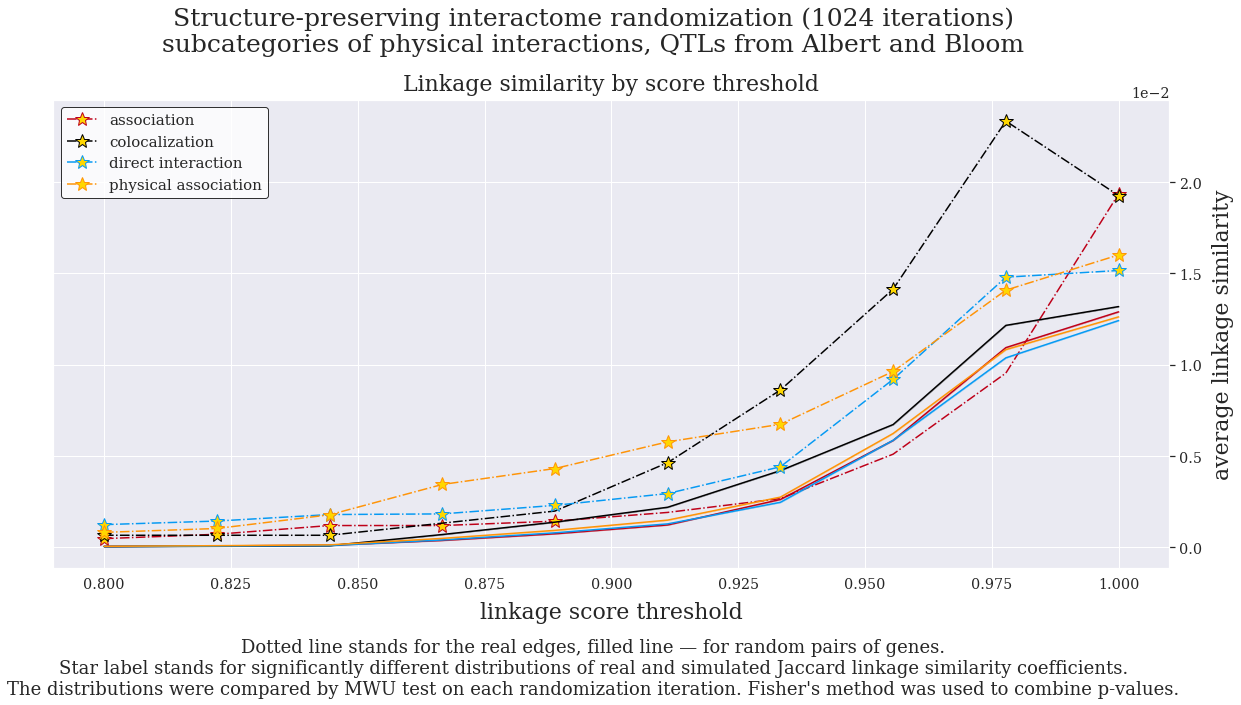

In [86]:
fig, ax = plt.subplots(figsize=(20,10))

plot_figure_2(
    fig, ax, type2interactome, type2simulation_results, 
    interaction_categories=physical_interaction_categories,
    score_thresholds=score_thresholds,
    colors=dict(zip(physical_interaction_categories, 
                    ["xkcd:scarlet", "black", "xkcd:azure", "xkcd:tangerine"])),
    suptitle="Structure-preserving interactome randomization (1024 iterations)\n"
             "subcategories of physical interactions, QTLs from Albert and Bloom", 
    caption="Dotted line stands for the real edges, filled line — for random pairs of genes.\n"
            "Star label stands for significantly different distributions of real and simulated "
            "Jaccard linkage similarity coefficients.\n"
            "The distributions were compared by MWU test on each randomization iteration. "
            "Fisher's method was used to combine p-values."
)

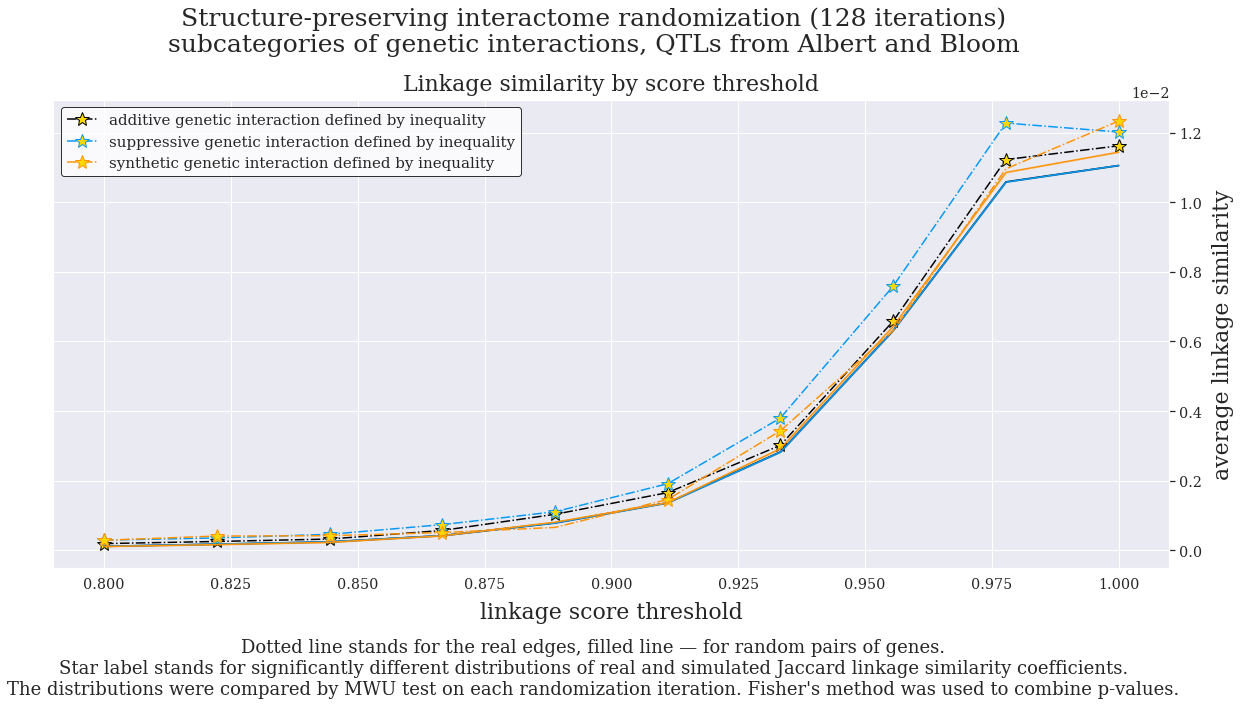

In [91]:
fig, ax = plt.subplots(figsize=(20,10))

plot_figure_2(
    fig, ax, type2interactome, type2simulation_results, 
    interaction_categories=genetic_interaction_categories,
    score_thresholds=score_thresholds,
    colors=dict(zip(genetic_interaction_categories, 
                    ["black", "xkcd:azure", "xkcd:tangerine"])),
    suptitle="Structure-preserving interactome randomization (128 iterations)\n"
             "subcategories of genetic interactions, QTLs from Albert and Bloom", 
    caption="Dotted line stands for the real edges, filled line — for random pairs of genes.\n"
            "Star label stands for significantly different distributions of real and simulated "
            "Jaccard linkage similarity coefficients.\n"
            "The distributions were compared by MWU test on each randomization iteration. "
            "Fisher's method was used to combine p-values."
)

## A&B's data, limix algorithm

In [ ]:
type2simulation_results = {}
score_thresholds = (10. ** np.arange(-8, -1))
assert np.all(score_thresholds == (10. ** np.arange(-8, -1)))
for edge_type in tqdm_notebook(interaction_categories):
    print(edge_type)
    rptest = RandomizedInteractomeTest(type2interactome[edge_type], 
                                       category[edge_type],
                                       qtls_df["eQTLs_2018"]["limix"],
                                       score_thresholds,
                                       "data/raw/randomized_interactome_copies/",
                                       max_iter=128, 
                                       n_jobs=score_thresholds.size)
    type2simulation_results[edge_type] = rptest.map_reduce()

In [ ]:
with open("data/tmp/figure-2/type2simulation_results_limix_eQTLs_2018.pkl", "wb") as outfile:
    pickle.dump(type2simulation_results, outfile)

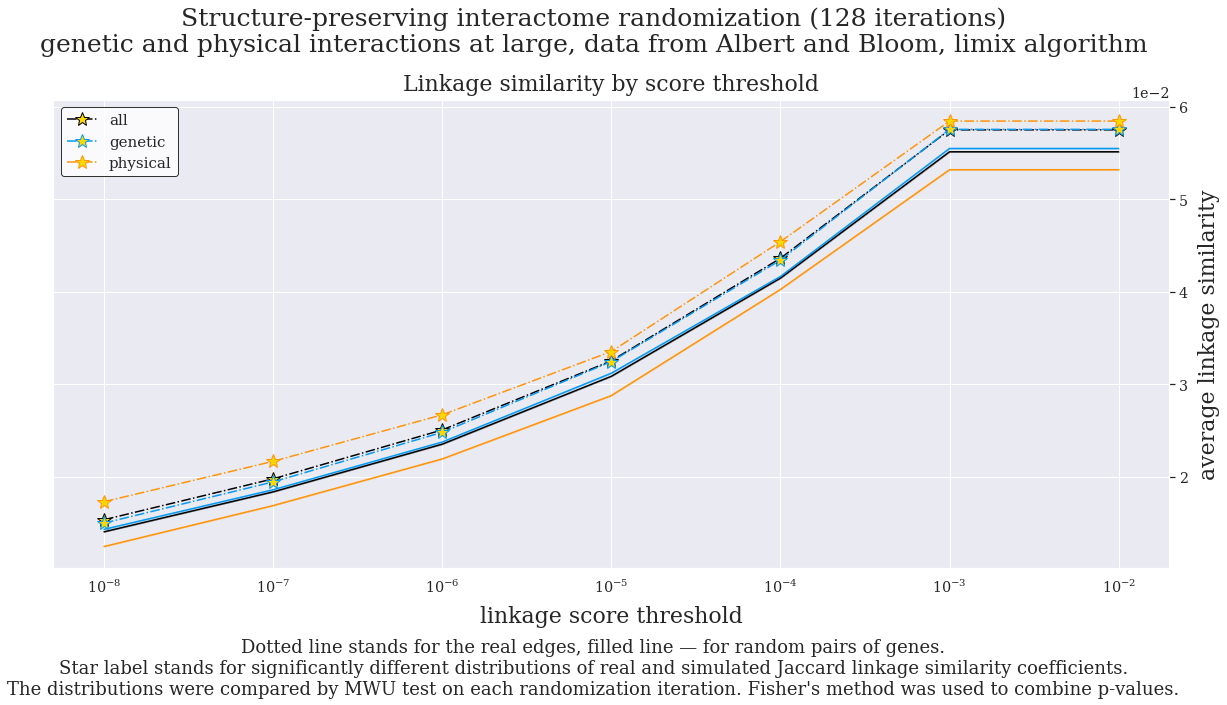

In [23]:
fig, ax = plt.subplots(figsize=(20,10))

plot_figure_2(
    fig, ax, type2interactome, type2simulation_results, 
    interaction_categories=["all", "genetic", "physical"],
    score_thresholds=score_thresholds,
    colors={"all" : "black",
            "genetic" : "xkcd:azure", 
            "physical" : "xkcd:tangerine"},
    suptitle="Structure-preserving interactome randomization (128 iterations)\n"
             "genetic and physical interactions at large, data from Albert and Bloom, limix algorithm", 
    caption="Dotted line stands for the real edges, filled line — for random pairs of genes.\n"
            "Star label stands for significantly different distributions of real and simulated "
            "Jaccard linkage similarity coefficients.\n"
            "The distributions were compared by MWU test on each randomization iteration. "
            "Fisher's method was used to combine p-values.",
    xscale_log=True
)

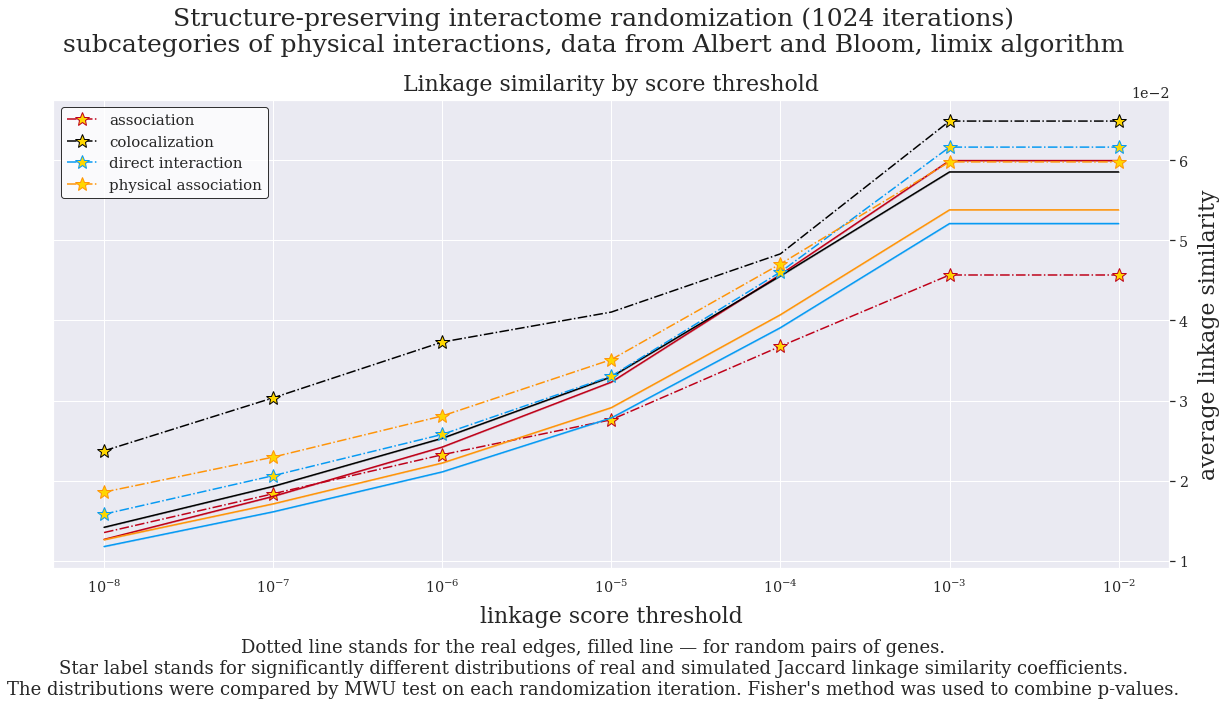

In [25]:
fig, ax = plt.subplots(figsize=(20,10))

plot_figure_2(
    fig, ax, type2interactome, type2simulation_results, 
    interaction_categories=physical_interaction_categories,
    score_thresholds=score_thresholds,
    colors=dict(zip(physical_interaction_categories, 
                    ["xkcd:scarlet", "black", "xkcd:azure", "xkcd:tangerine"])),
    suptitle="Structure-preserving interactome randomization (1024 iterations)\n"
             "subcategories of physical interactions, data from Albert and Bloom, limix algorithm", 
    caption="Dotted line stands for the real edges, filled line — for random pairs of genes.\n"
            "Star label stands for significantly different distributions of real and simulated "
            "Jaccard linkage similarity coefficients.\n"
            "The distributions were compared by MWU test on each randomization iteration. "
            "Fisher's method was used to combine p-values.",
    xscale_log=True
)

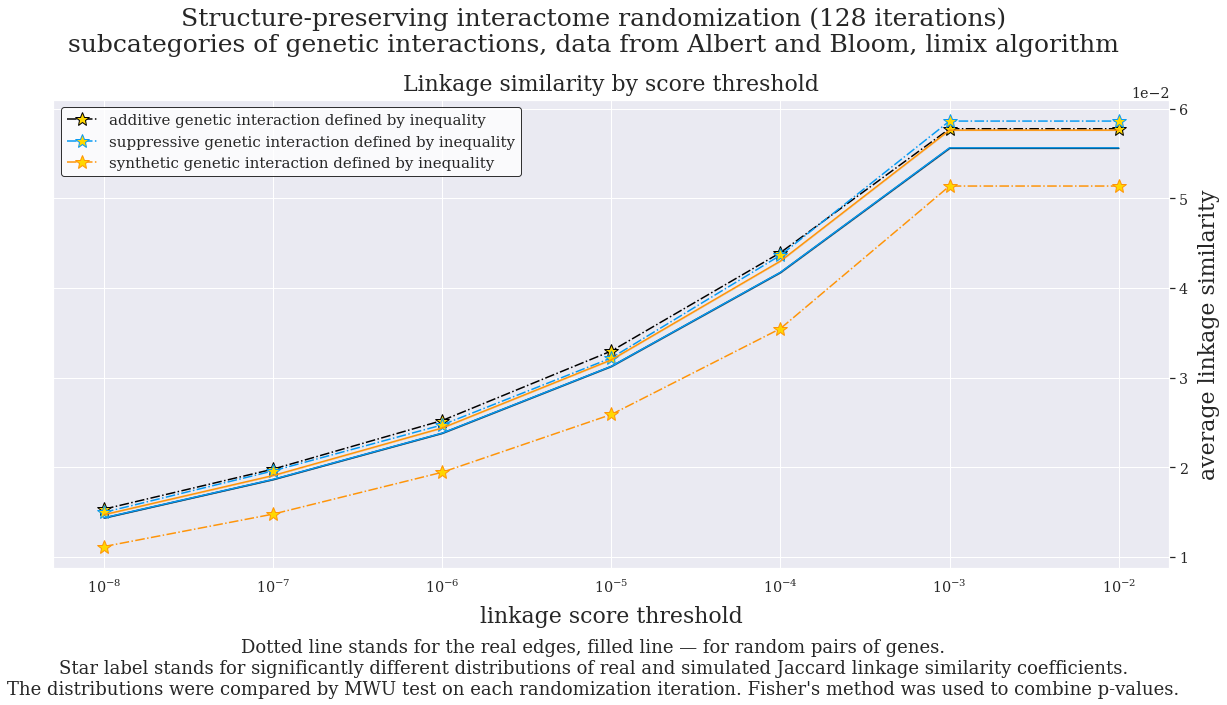

In [26]:
fig, ax = plt.subplots(figsize=(20,10))

plot_figure_2(
    fig, ax, type2interactome, type2simulation_results, 
    interaction_categories=genetic_interaction_categories,
    score_thresholds=score_thresholds,
    colors=dict(zip(genetic_interaction_categories, 
                    ["black", "xkcd:azure", "xkcd:tangerine"])),
    suptitle="Structure-preserving interactome randomization (128 iterations)\n"
             "subcategories of genetic interactions, data from Albert and Bloom, limix algorithm", 
    caption="Dotted line stands for the real edges, filled line — for random pairs of genes.\n"
            "Star label stands for significantly different distributions of real and simulated "
            "Jaccard linkage similarity coefficients.\n"
            "The distributions were compared by MWU test on each randomization iteration. "
            "Fisher's method was used to combine p-values.",
    xscale_log=True
)

## Our old eQTLs, naive algorithm:

In [ ]:
""" Run simulations from scratch and dump results on disk. """

type2simulation_results = {}
score_thresholds = (10. ** np.arange(-8, -1))
assert np.all(score_thresholds == (10. ** np.arange(-8, -1)))
for edge_type in tqdm_notebook(interaction_categories):
#     if edge_type not in ["all", "genetic", "physical"]:
#         continue
    print(edge_type)
#     for edge_type in ["all", "genetic"]:
    rptest = RandomizedInteractomeTest(type2interactome[edge_type], 
                                       category[edge_type],
                                       qtls_df["eQTLs_2011"]["naive"],
                                       score_thresholds,
                                       "data/raw/randomized_interactome_copies/",
                                       max_iter=128, 
                                       n_jobs=min(32, score_thresholds.size))
    type2simulation_results[edge_type] = rptest.map_reduce()

In [25]:
with open("data/tmp/figure-2/type2simulation_results_naive_eQTLs_2011.pkl", "wb") as outfile:
    pickle.dump(type2simulation_results, outfile)

additive genetic interaction defined by inequality
suppressive genetic interaction defined by inequality
synthetic genetic interaction defined by inequality
association
colocalization
direct interaction
physical association
all
physical
genetic



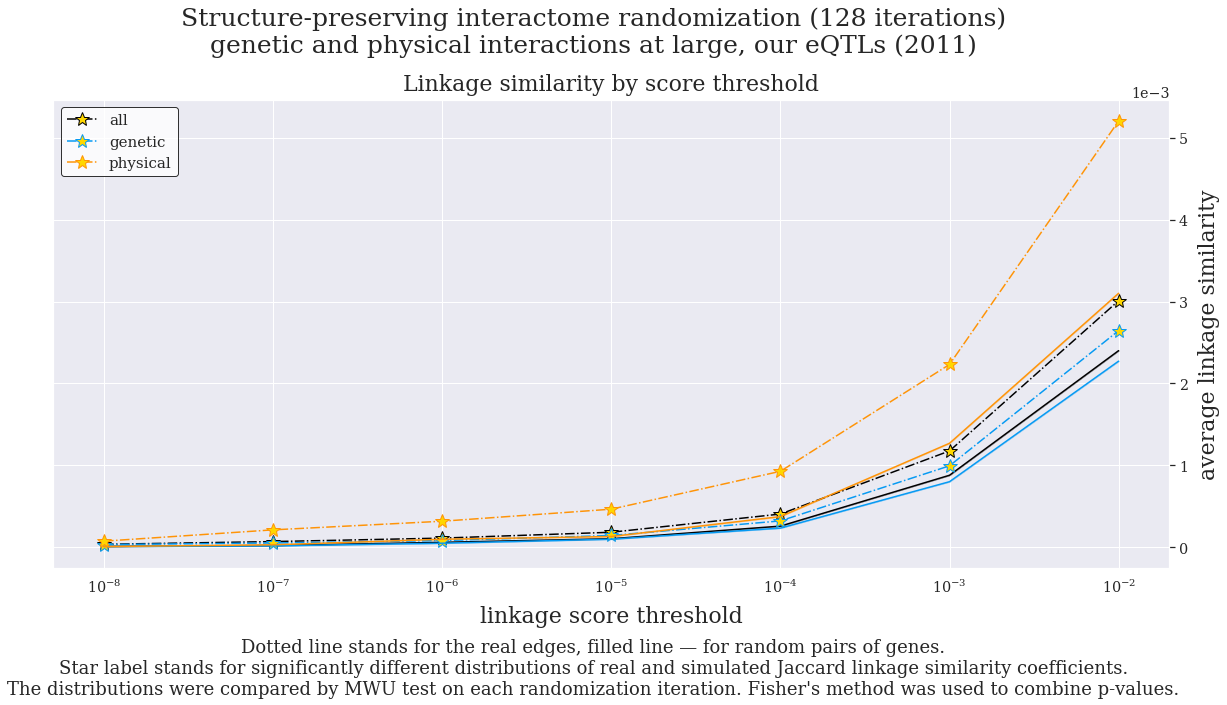

In [28]:
fig, ax = plt.subplots(figsize=(20,10))
plot_figure_2(
    fig, ax, type2interactome, type2simulation_results, 
    interaction_categories=["all", "genetic", "physical"],
    score_thresholds=score_thresholds,
    colors={"all" : "black",
            "genetic" : "xkcd:azure", 
            "physical" : "xkcd:tangerine"},
    suptitle="Structure-preserving interactome randomization (128 iterations)\n"
             "genetic and physical interactions at large, our eQTLs (2011)", 
    caption="Dotted line stands for the real edges, filled line — for random pairs of genes.\n"
            "Star label stands for significantly different distributions of real and simulated "
            "Jaccard linkage similarity coefficients.\n"
            "The distributions were compared by MWU test on each randomization iteration. "
            "Fisher's method was used to combine p-values.",
    xscale_log=True
)

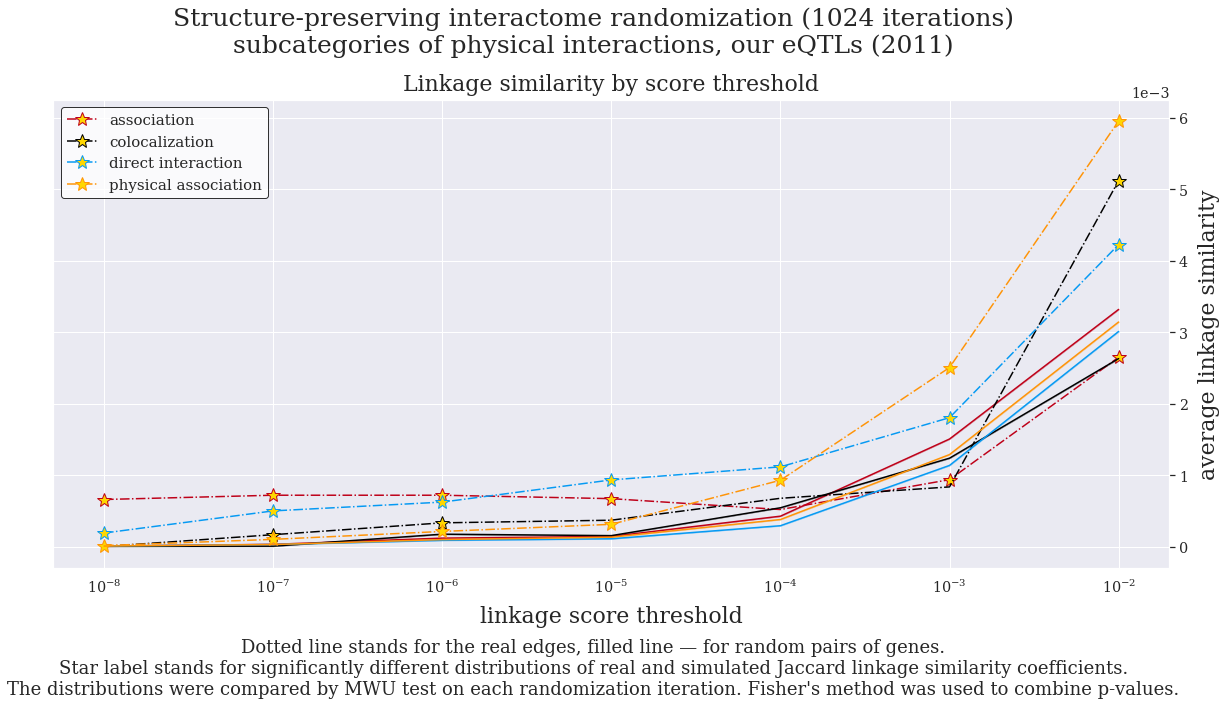

In [30]:
fig, ax = plt.subplots(figsize=(20,10))

plot_figure_2(
    fig, ax, type2interactome, type2simulation_results, 
    interaction_categories=physical_interaction_categories,
    score_thresholds=score_thresholds,
    colors=dict(zip(physical_interaction_categories, 
                    ["xkcd:scarlet", "black", "xkcd:azure", "xkcd:tangerine"])),
    suptitle="Structure-preserving interactome randomization (1024 iterations)\n"
             "subcategories of physical interactions, our eQTLs (2011)", 
    caption="Dotted line stands for the real edges, filled line — for random pairs of genes.\n"
            "Star label stands for significantly different distributions of real and simulated "
            "Jaccard linkage similarity coefficients.\n"
            "The distributions were compared by MWU test on each randomization iteration. "
            "Fisher's method was used to combine p-values.",
    xscale_log=True
)

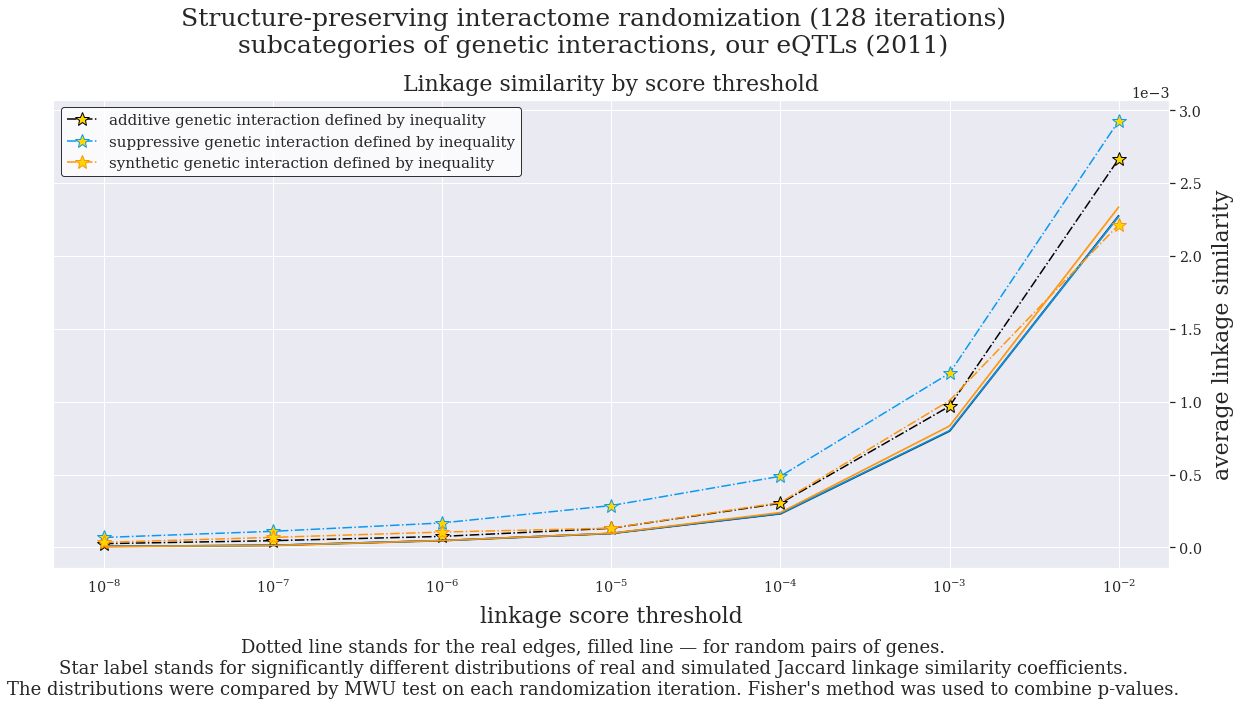

In [32]:
fig, ax = plt.subplots(figsize=(20,10))
plot_figure_2(
    fig, ax, type2interactome, type2simulation_results, 
    interaction_categories=genetic_interaction_categories,
    score_thresholds=score_thresholds,
    colors=dict(zip(genetic_interaction_categories, 
                    ["black", "xkcd:azure", "xkcd:tangerine"])),
    suptitle="Structure-preserving interactome randomization (128 iterations)\n"
             "subcategories of genetic interactions, our eQTLs (2011)", 
    caption="Dotted line stands for the real edges, filled line — for random pairs of genes.\n"
            "Star label stands for significantly different distributions of real and simulated "
            "Jaccard linkage similarity coefficients.\n"
            "The distributions were compared by MWU test on each randomization iteration. "
            "Fisher's method was used to combine p-values.",
    xscale_log=True
)

## Our old eQTLs, limix algorithm

In [16]:
""" Run simulations from scratch and dump results on disk. """

type2simulation_results = {}
score_thresholds = (10. ** np.arange(-8, -1))
assert np.all(score_thresholds == (10. ** np.arange(-8, -1)))
for edge_type in tqdm_notebook(interaction_categories):
    print(edge_type)
    rptest = RandomizedInteractomeTest(type2interactome[edge_type], 
                                       category[edge_type],
                                       qtls_df["eQTLs_2011"]["limix"],
                                       score_thresholds,
                                       "data/raw/randomized_interactome_copies/",
                                       max_iter=128, 
                                       n_jobs=min(32, score_thresholds.size))
    type2simulation_results[edge_type] = rptest.map_reduce()

additive genetic interaction defined by inequality
suppressive genetic interaction defined by inequality
synthetic genetic interaction defined by inequality
association
colocalization
direct interaction
physical association
all
physical
genetic



In [17]:
with open("data/tmp/figure-2/type2simulation_results_limix_eQTLs_2011.pkl", "wb") as outfile:
    pickle.dump(type2simulation_results, outfile)

In [4]:
with open("data/tmp/figure-2/type2simulation_results_limix_eQTLs_2011.pkl", "rb") as infile:
    type2simulation_results = pickle.load(infile)

FileNotFoundError: [Errno 2] No such file or directory: 'data/tmp/figure-2/type2simulation_results_limix_eQTLs_2011.pkl'

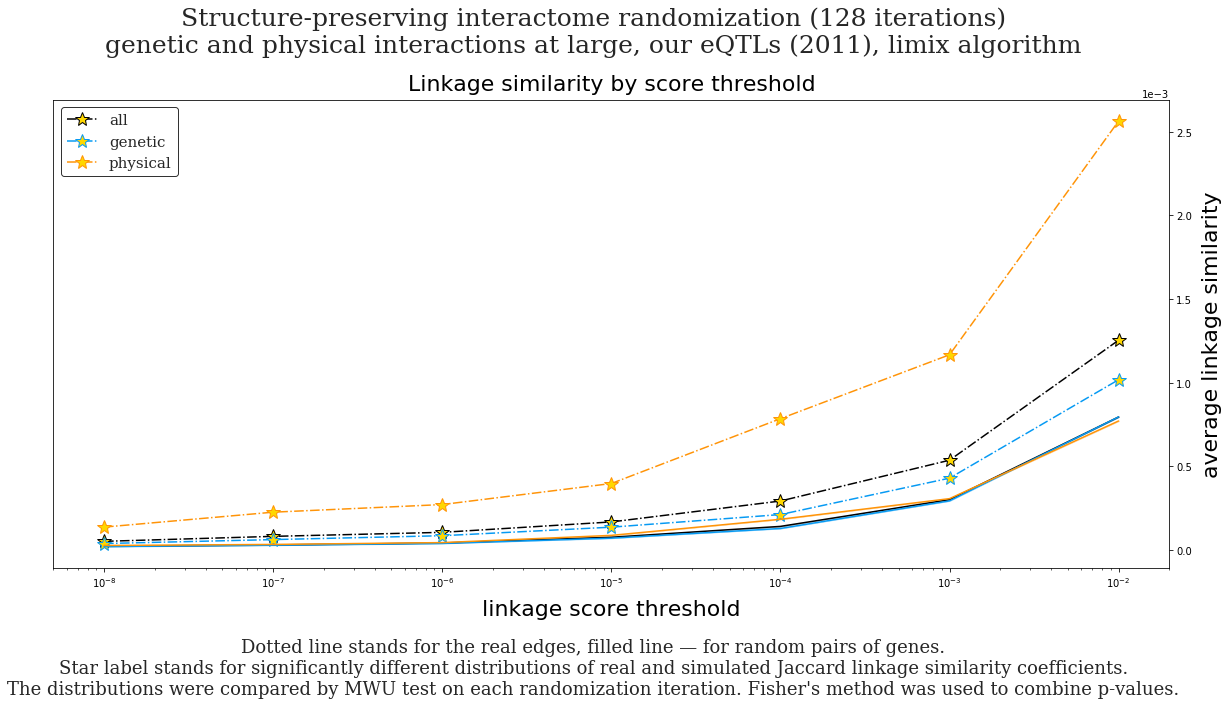

In [18]:
fig, ax = plt.subplots(figsize=(20,10))
plot_figure_2(
    fig, ax, type2interactome, type2simulation_results, 
    interaction_categories=["all", "genetic", "physical"],
    score_thresholds=score_thresholds,
    colors={"all" : "black",
            "genetic" : "xkcd:azure", 
            "physical" : "xkcd:tangerine"},
    suptitle="Structure-preserving interactome randomization (128 iterations)\n"
             "genetic and physical interactions at large, our eQTLs (2011), limix algorithm", 
    caption="Dotted line stands for the real edges, filled line — for random pairs of genes.\n"
            "Star label stands for significantly different distributions of real and simulated "
            "Jaccard linkage similarity coefficients.\n"
            "The distributions were compared by MWU test on each randomization iteration. "
            "Fisher's method was used to combine p-values.",
    xscale_log=True
)

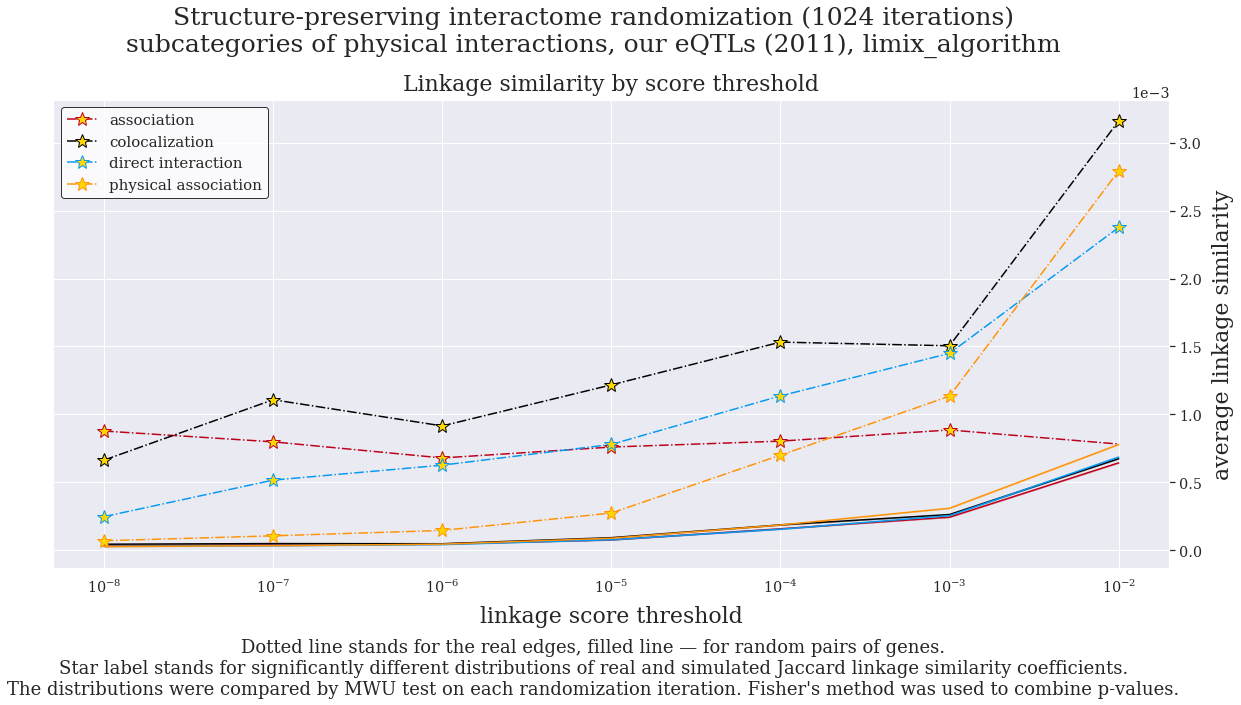

In [19]:
fig, ax = plt.subplots(figsize=(20,10))

plot_figure_2(
    fig, ax, type2interactome, type2simulation_results, 
    interaction_categories=physical_interaction_categories,
    score_thresholds=score_thresholds,
    colors=dict(zip(physical_interaction_categories, 
                    ["xkcd:scarlet", "black", "xkcd:azure", "xkcd:tangerine"])),
    suptitle="Structure-preserving interactome randomization (1024 iterations)\n"
             "subcategories of physical interactions, our eQTLs (2011), limix_algorithm", 
    caption="Dotted line stands for the real edges, filled line — for random pairs of genes.\n"
            "Star label stands for significantly different distributions of real and simulated "
            "Jaccard linkage similarity coefficients.\n"
            "The distributions were compared by MWU test on each randomization iteration. "
            "Fisher's method was used to combine p-values.",
    xscale_log=True
)

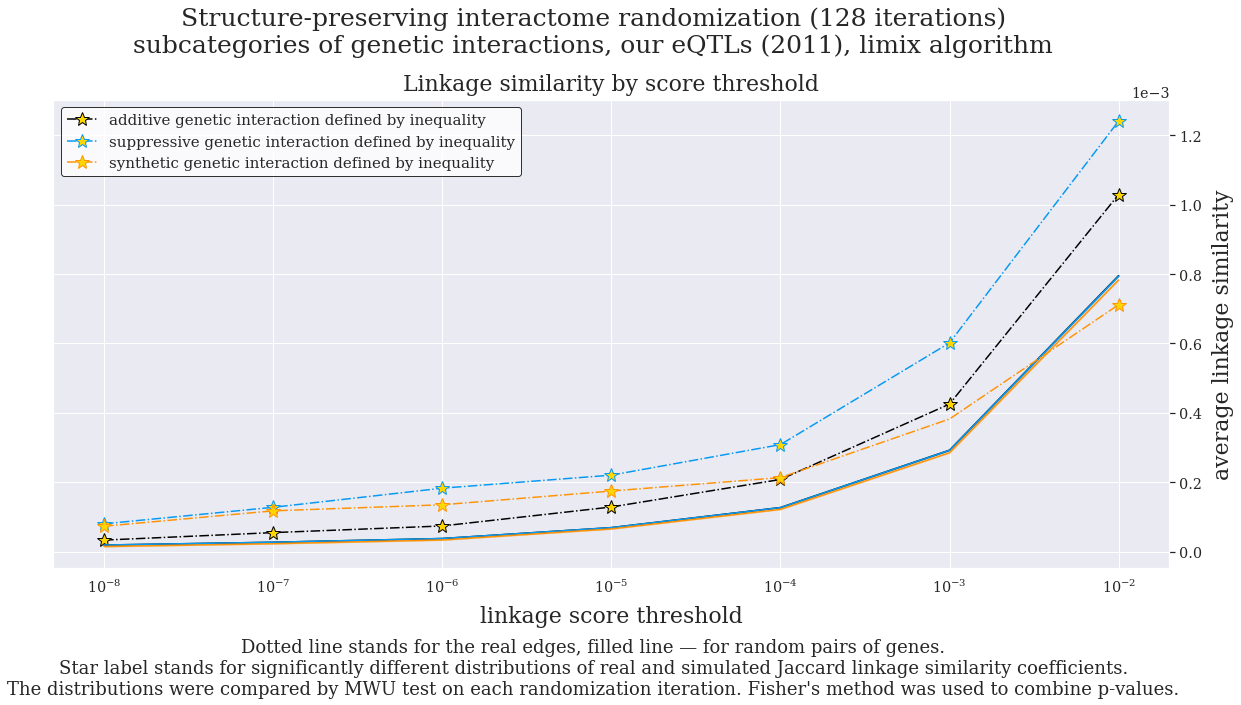

In [20]:
fig, ax = plt.subplots(figsize=(20,10))
plot_figure_2(
    fig, ax, type2interactome, type2simulation_results, 
    interaction_categories=genetic_interaction_categories,
    score_thresholds=score_thresholds,
    colors=dict(zip(genetic_interaction_categories, 
                    ["black", "xkcd:azure", "xkcd:tangerine"])),
    suptitle="Structure-preserving interactome randomization (128 iterations)\n"
             "subcategories of genetic interactions, our eQTLs (2011), limix algorithm", 
    caption="Dotted line stands for the real edges, filled line — for random pairs of genes.\n"
            "Star label stands for significantly different distributions of real and simulated "
            "Jaccard linkage similarity coefficients.\n"
            "The distributions were compared by MWU test on each randomization iteration. "
            "Fisher's method was used to combine p-values.",
    xscale_log=True
)

## Our old pQTLs

In [33]:
""" Run simulations from scratch and dump results on disk. """

type2simulation_results = {}
score_thresholds = (10. ** np.arange(-8, -1))
assert np.all(score_thresholds == (10. ** np.arange(-8, -1)))
for edge_type in tqdm_notebook(interaction_categories):
#     if edge_type not in ["all", "genetic", "physical"]:
#         continue
    print(edge_type)
#     for edge_type in ["all", "genetic"]:
    rptest = RandomizedInteractomeTest(type2interactome[edge_type], 
                                       category[edge_type],
                                       qtls_df["pQTLs_2011"],
                                       score_thresholds,
                                       "data/raw/randomized_interactome_copies/",
                                       max_iter=128, 
                                       n_jobs=min(32, score_thresholds.size))
    type2simulation_results[edge_type] = rptest.map_reduce()

additive genetic interaction defined by inequality
suppressive genetic interaction defined by inequality
synthetic genetic interaction defined by inequality
association
colocalization
direct interaction
physical association
all
physical
genetic



In [34]:
with open("data/tmp/figure-2/type2simulation_results_naive_pQTLs_2011.pkl", "wb") as outfile:
    pickle.dump(type2simulation_results, outfile)

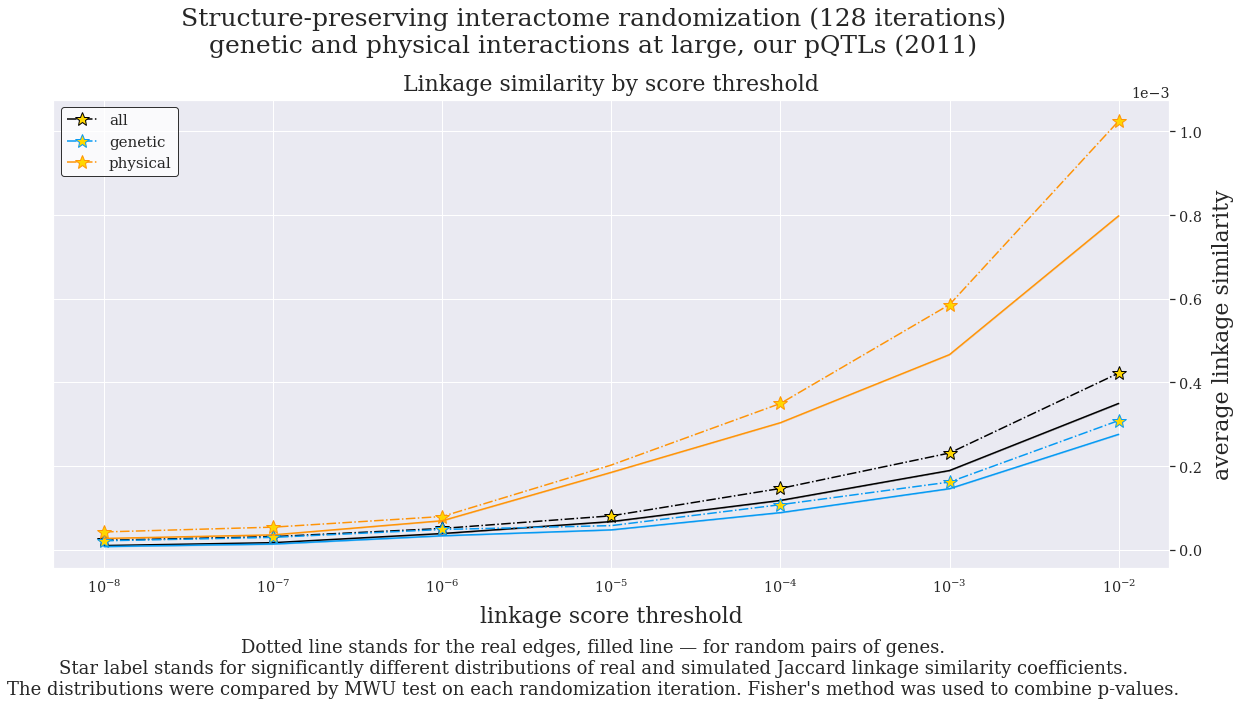

In [35]:
fig, ax = plt.subplots(figsize=(20,10))
plot_figure_2(
    fig, ax, type2interactome, type2simulation_results, 
    interaction_categories=["all", "genetic", "physical"],
    score_thresholds=score_thresholds,
    colors={"all" : "black",
            "genetic" : "xkcd:azure", 
            "physical" : "xkcd:tangerine"},
    suptitle="Structure-preserving interactome randomization (128 iterations)\n"
             "genetic and physical interactions at large, our pQTLs (2011)", 
    caption="Dotted line stands for the real edges, filled line — for random pairs of genes.\n"
            "Star label stands for significantly different distributions of real and simulated "
            "Jaccard linkage similarity coefficients.\n"
            "The distributions were compared by MWU test on each randomization iteration. "
            "Fisher's method was used to combine p-values.",
    xscale_log=True
)

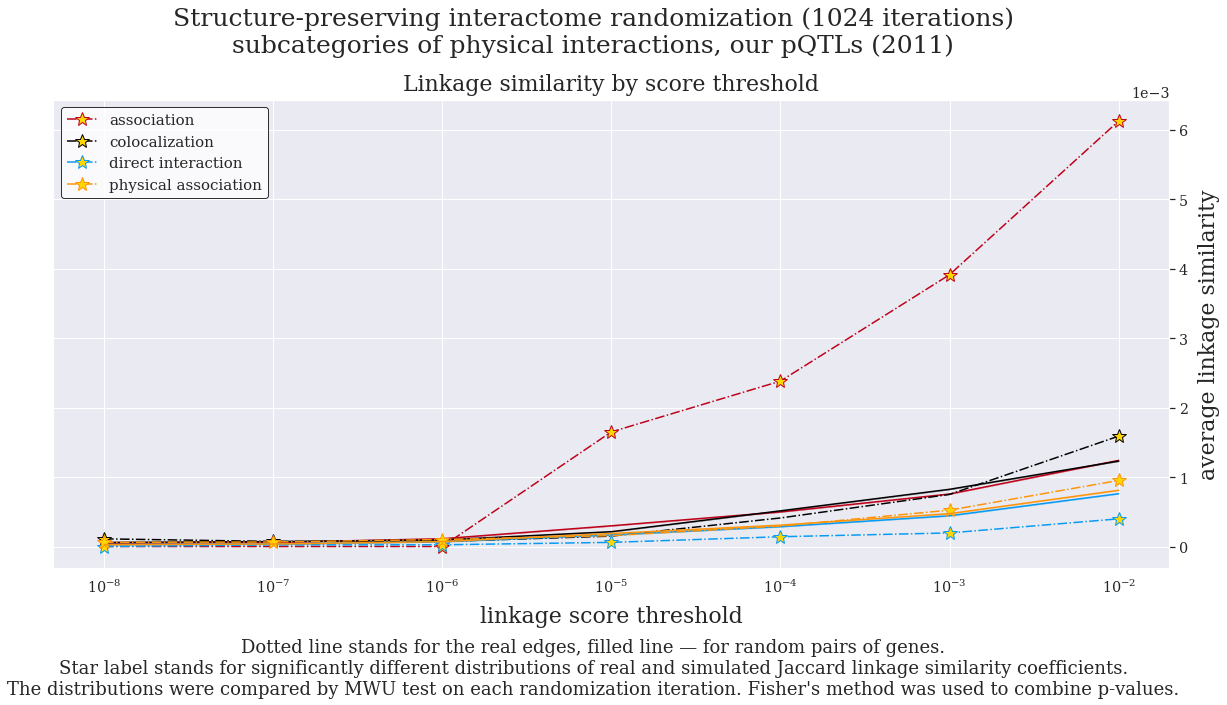

In [36]:
fig, ax = plt.subplots(figsize=(20,10))

plot_figure_2(
    fig, ax, type2interactome, type2simulation_results, 
    interaction_categories=physical_interaction_categories,
    score_thresholds=score_thresholds,
    colors=dict(zip(physical_interaction_categories, 
                    ["xkcd:scarlet", "black", "xkcd:azure", "xkcd:tangerine"])),
    suptitle="Structure-preserving interactome randomization (1024 iterations)\n"
             "subcategories of physical interactions, our pQTLs (2011)", 
    caption="Dotted line stands for the real edges, filled line — for random pairs of genes.\n"
            "Star label stands for significantly different distributions of real and simulated "
            "Jaccard linkage similarity coefficients.\n"
            "The distributions were compared by MWU test on each randomization iteration. "
            "Fisher's method was used to combine p-values.",
    xscale_log=True
)

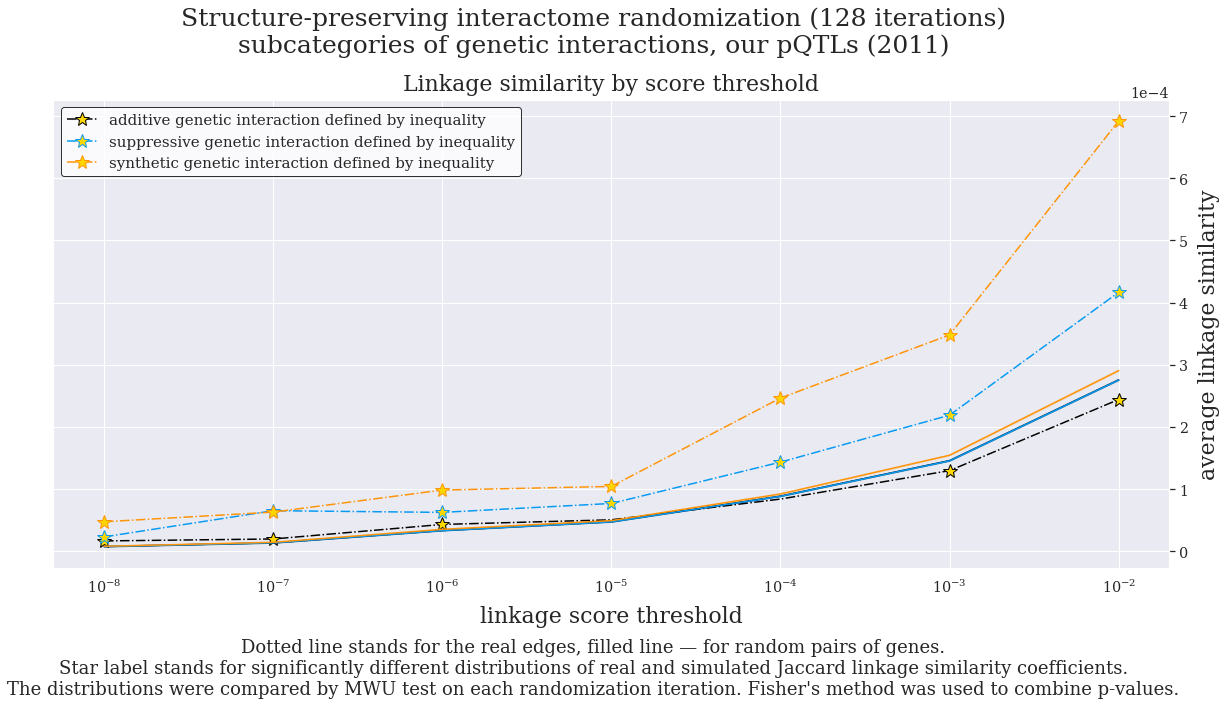

In [37]:
fig, ax = plt.subplots(figsize=(20,10))
plot_figure_2(
    fig, ax, type2interactome, type2simulation_results, 
    interaction_categories=genetic_interaction_categories,
    score_thresholds=score_thresholds,
    colors=dict(zip(genetic_interaction_categories, 
                    ["black", "xkcd:azure", "xkcd:tangerine"])),
    suptitle="Structure-preserving interactome randomization (128 iterations)\n"
             "subcategories of genetic interactions, our pQTLs (2011)", 
    caption="Dotted line stands for the real edges, filled line — for random pairs of genes.\n"
            "Star label stands for significantly different distributions of real and simulated "
            "Jaccard linkage similarity coefficients.\n"
            "The distributions were compared by MWU test on each randomization iteration. "
            "Fisher's method was used to combine p-values.",
    xscale_log=True
)